# Tutorial 15: Physics-informed DMD

In this tutorial, we demonstrate how one may use the PyDMD package in order to apply physics-informed DMD (PiDMD) [1] to data. We begin with a brief introduction to the theory behind the method, in addition to an exhaustive overview of the PiDMD matrix manifolds currently avaialble for use in PyDMD. We then demonstrate how one may apply PiDMD to data for improved DMD model performance and robustness.

[1] Baddoo Peter J., Herrmann Benjamin, McKeon Beverley J., Nathan Kutz J., and Brunton Steven L. 2023 Physics-informed dynamic mode decomposition. *Proc. R. Soc. A.* **479:** 20220576. 20220576.
http://doi.org/10.1098/rspa.2022.0576

We begin by importing the `DMD` and `PiDMD` classes from PyDMD, along with `numpy` for mathematical computations and `matplotlib.pyplot` for plotting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD
from pydmd.pidmd import PiDMD

## Part 1: PiDMD Manifolds
In contrast to exact DMD, which seeks a best-fit rank-$r$ linear operator that advances one's measurement data $\mathbf{X}, \mathbf{Y}$ forward in time via the optimization

$$
\mathbf{A}_{\text{DMD}} = \text{arg min}_{\text{rank}(\mathbf{A})\leq r}\|\mathbf{Y} - \mathbf{AX}\|_F,
$$

physics-informed DMD instead seeks such an operator that is *additionally* constrained to be a member of some manifold of matrices $\mathcal{M}$ via the optimization

$$
\mathbf{A}_{\text{PiDMD}} = \text{arg min}_{\mathbf{A} \in \mathcal{M}}\|\mathbf{Y} - \mathbf{AX}\|_F.
$$

In doing so, we restrict ourselves to a smaller family of candidate DMD operators $\mathbf{A}$, which thus improves the robustness of the algorithm and reduces our chances of overfitting. As discussed in [1], the manifold $\mathcal{M}$ is chosen by the user, and it is often determined by apriori knowledge of the physics that govern the system at hand. We will briefly discuss these principles more throughout the tutorial, however we direct readers to [1] for further details and reading.

Below is an exhaustive list of all of the matrix manifolds currently available for use in the PyDMD implementation of PiDMD. Please refer to the following demos, or to the `PiDMD` class documentation found [here](https://github.com/PyDMD/PyDMD/blob/master/pydmd/pidmd.py) for the string arguments that correspond with each available manifold.

| Physical Principles | Matrix Manifolds |
|:---|:---|
| Conservative systems | <ul><li>unitary</li></ul>|
| Causal systems | <ul><li>upper triangular</li><li>lower triangular</li></ul> |
| Local systems | <ul><li>banded diagonal</li><li>symmetric and tridiagonal</li></ul> |
| Self-adoint systems | <ul><li>symmetric</li><li>skew-symmetric</li></ul>|
| Shift-equivariant systems | <ul><li>toeplitz</li><li>hankel</li><li>circulant</li><li>circulant and unitary</li><li>circulant and symmetric</li><li>circulant and skew-symmetric</li></ul> |
| Multi-dimensional extensions | <ul><li>block circulant</li><li>block circulant with tridiagonal blocks</li><li>block circulant with circulant blocks</li><li>block circulant with circulant blocks, and unitary</li><li>block circulant with circulant blocks, and symmetric</li><li>block circulant with circulant blocks, and skew-symmetric</li></ul> |

We now demonstrate the usage of each manifold by applying PiDMD to a random "data" matrix $\mathbf{X}$, which we define here. We additionally define a helper method for matrix plotting so that we may easily visualize the members of each manifold. We also define a method for relative error computations.

In [2]:
"""
Define test data and test data sizes.
"""
nx = 8 # snapshot size
nt = 1000 # number of samples
rng = np.random.default_rng(seed=42) # seed for reproducibility
X = rng.standard_normal((nx, nt)) # random "data" matrix

def plot_matrices(figsize, grid, matrices, titles):
    """
    Helper function for plotting demo matrices.
    """
    plt.figure(figsize=figsize)
    for i, A in enumerate(matrices):
        vmax = np.abs(A).max()
        plt.subplot(grid[0], grid[1], i + 1)
        plt.title(titles[i])
        plt.imshow(A.real, cmap="bwr", vmax=vmax, vmin=-vmax)
        plt.colorbar()
    plt.tight_layout()
    plt.show()

def compute_error(true, est):
    """
    Computes and returns relative error.
    """
    return np.linalg.norm(true - est) / np.linalg.norm(true)

## Conservative systems
If we let $E(\mathbf{x}) = \|\mathbf{x}\|_2^2$ denote some conserved quantity of the state (i.e. energy, momentum, etc.), then the following must hold in order for $E$ to be conserved.

$$
E(\mathbf{Ax}) = \|\mathbf{Ax}\|_2^2 = \|\mathbf{x}\|_2^2 = E(\mathbf{x}) \quad \forall \mathbf{x} \in \mathbb{R}^n
$$

This holds if and only if the discrete-time forward operator $\mathbf{A}$ is *unitary*, which we can enforce by setting `manifold="unitary"` when initializing our `PiDMD` model. Note that by default, `PiDMD` models do *not* explicitly compute the operator $\mathbf{A}$ in order to avoid excessively expensive computations. Here, we ask our `PiDMD` model to compute $\mathbf{A}$ via `compute_A=True` for visualization purposes, and because our data is small enough for this to be computationally feasible. 

In [3]:
pidmd = PiDMD(manifold="unitary", compute_A=True)
pidmd.fit(X)

We now plot the matrix $\mathbf{A}$, which may be accessed via the `PiDMD` model property `A`, along with the matrix product $\mathbf{A}^*\mathbf{A}$, which we note equals the identity matrix for unitary matrices. Notice that in the plot below, we indeed find this to be true. We additionally plot the eigenvalues of $\mathbf{A}$, which may be accessed via the `PiDMD` property `eigs`. Notice that the eigenvalues of $\mathbf{A}$ lie on the unit circle, and that we indeed find that the quantity $E(\mathbf{x})$ is conserved over time.

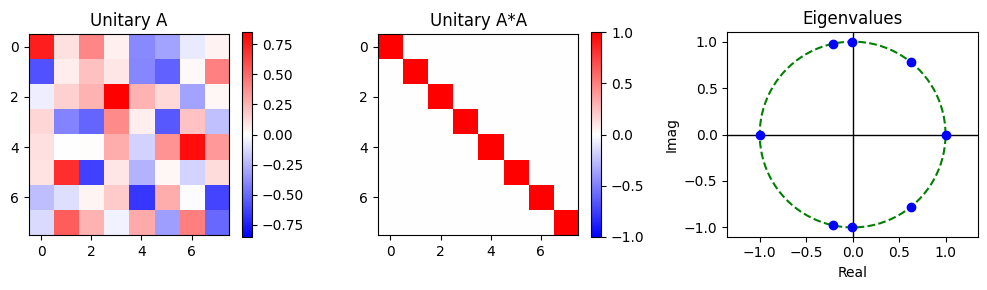

Relative error between ‖x‖ and ‖Ax‖ across all x:
6.24107056718562e-16


In [4]:
# Plot A and A*A matrices (real components).
plt.figure(figsize=(10, 3))
for i, (A, title) in enumerate(
    zip([pidmd.A, pidmd.A.conj().T.dot(pidmd.A)], ["Unitary A", "Unitary A*A"])
):
    vmax = np.abs(A).max()
    plt.subplot(1, 3, i + 1)
    plt.imshow(A.real, cmap="bwr", vmax=vmax, vmin=-vmax)
    plt.title(title)
    plt.colorbar()

plt.subplot(1, 3, 3)
# Plot the complex plane and the unit circle.
plt.axvline(x=0, c="k", lw=1)
plt.axhline(y=0, c="k", lw=1)
t = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(t), np.sin(t), c="g", ls="--")
# Plot the eigenvalues.
plt.plot(pidmd.eigs.real, pidmd.eigs.imag, "o", c="b")
plt.title("Eigenvalues")
plt.xlabel("Real")
plt.ylabel("Imag")
plt.axis("equal")
plt.tight_layout()
plt.show()

# Verify conservation.
print("Relative error between ‖x‖ and ‖Ax‖ across all x:")
print(compute_error(np.linalg.norm(X, 2, axis=0), np.linalg.norm(pidmd.A.dot(X), 2, axis=0)))

## Causal systems

When examining data where the $j$th state $x_j$ is impacted only by the "upstream" states $x_j, x_{j+1}, x_{j+2}, \dots,$ we note that we are dealing with a system with causal structure, in which case we can infer that the discrete-time forward operator $\mathbf{A}$ takes on an *upper triangular* structure. Likewise, we might infer that $\mathbf{A}$ is *lower triangular*, depending on the direction of causality. These are again structures that we can enforce via the `manifold` argument of the `PiDMD` class.

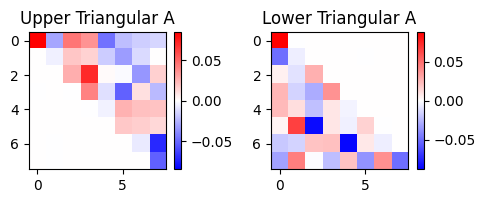

In [5]:
# Define and fit causal PiDMD models.
pidmd_ut = PiDMD(manifold="uppertriangular", compute_A=True).fit(X)
pidmd_lt = PiDMD(manifold="lowertriangular", compute_A=True).fit(X)

# Plot the computed A matrices (real components).
plot_matrices(
    figsize=(5, 2), grid=(1, 2),
    matrices=[pidmd_ut.A, pidmd_lt.A], 
    titles=["Upper Triangular A", "Lower Triangular A"],
)

## Local systems

Similar to the case of the causal system, when examining data where the $j$th state $x_j$ is impacted only by its neighboring states $x_j, x_{j-1}, x_{j+1},\dots,$ we note that we are dealing with a system with spatial locality, in which case we may infer that the discrete-time forward operator $\mathbf{A}$ takes on a *banded diagonal* form.

We can specify this for a `PiDMD` model by setting `manifold="diagonal"`. We can also combine this with the use of the `manifold_opt` argument of the `PiDMD` class to specify our desired bandwidths, as demonstrated below. By default, using `manifold="diagonal"` will yield a diagonal $\mathbf{A}$ operator. However, specifying `manifold_opt=k` for some integer $k$ will yield a banded operator with a lower and upper bandwidth of $k-1$. We can additionally obtain a banded operator with a lower bandwidth of $k_1-1$ and an upper bandwidth of $k_2-1$ by specifying `manifold_opt=(k1, k2)`, as discussed in the `PiDMD` class documentation found [here](https://github.com/PyDMD/PyDMD/blob/master/pydmd/pidmd.py). Note that the `manifold_opt` argument is often optional, as it only pertains to certain manifolds that require further specifications.

Another family of local operators is the manifold of *symmetric tridiagonal* operators. These may be built by setting `manifold="symmetric_tridiagonal"`.

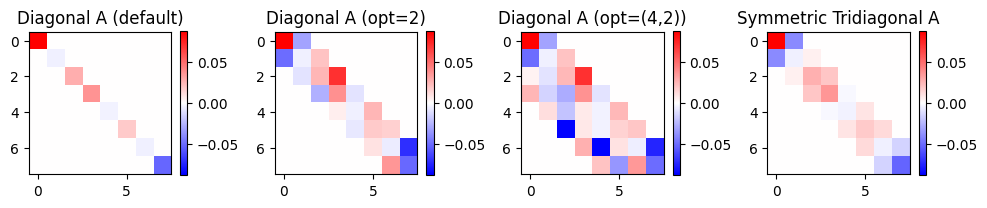

In [6]:
# Define and fit local PiDMD models.
pidmd_d1 = PiDMD(manifold="diagonal", compute_A=True).fit(X)
pidmd_d2 = PiDMD(manifold="diagonal", manifold_opt=2, compute_A=True).fit(X)
pidmd_d3 = PiDMD(manifold="diagonal", manifold_opt=(4, 2), compute_A=True).fit(X)
pidmd_d4 = PiDMD(manifold="symmetric_tridiagonal", compute_A=True).fit(X)

# Plot the computed A matrices (real components).
plot_matrices(
    figsize=(10, 2), grid=(1, 4),
    matrices=[pidmd_d1.A, pidmd_d2.A, pidmd_d3.A, pidmd_d4.A], 
    titles=["Diagonal A (default)", "Diagonal A (opt=2)", "Diagonal A (opt=(4,2))", "Symmetric Tridiagonal A"],
)

## Self-adjoint systems

Self-adjoint systems, which are characterized by *symmetric* discrete-time forward operators $\mathbf{A}$ and real eigenvalues, are additionally avaiable for use in PyDMD. A similar family of matrices also available for use is the manifold of *skew-symmetric* operators, which we note possess purely imaginary eigenvalues. Below, we demonstrate how one may enforce such manifolds via the `PiDMD` module. We additionally visualize the corresponding operator eigenvalues.

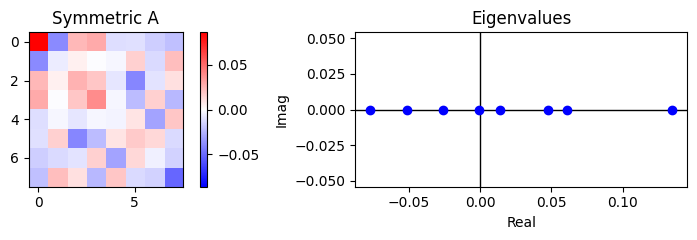

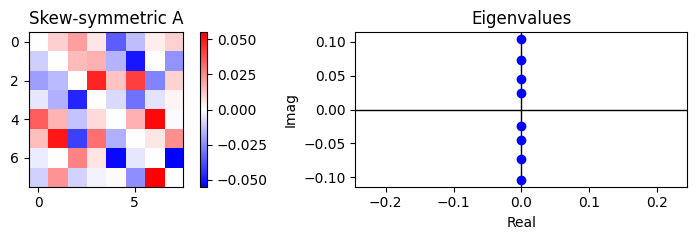

In [7]:
# Define and fit symmetric and skew-symmetric PiDMD models.
pidmd_s = PiDMD(manifold="symmetric", compute_A=True).fit(X)
pidmd_ss = PiDMD(manifold="skewsymmetric", compute_A=True).fit(X)

for pidmd, title in zip([pidmd_s, pidmd_ss], ["Symmetric", "Skew-symmetric"]):
    plt.figure(figsize=(8, 2.5))
    # Plot the computed A matrix (real components).
    plt.subplot(1, 2, 1)
    vmax = np.abs(pidmd.A).max()
    plt.imshow(pidmd.A.real, cmap="bwr", vmax=vmax, vmin=-vmax)
    plt.title(f"{title} A")
    plt.colorbar()
    # Plot eigenvalues in complex plane.
    plt.subplot(1, 2, 2)
    plt.axvline(x=0, c="k", lw=1)
    plt.axhline(y=0, c="k", lw=1)
    plt.plot(pidmd.eigs.real, pidmd.eigs.imag, "o", c="b")
    plt.title("Eigenvalues")
    plt.xlabel("Real")
    plt.ylabel("Imag")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

## Shift-equivariant systems

Shift-equivariant systems, or systems that appear identical with respect to a stationary observer, possess continuous-time forward operators $\mathcal{A}$ that commute with the the $\phi$-shift operator $\mathcal{S}_\phi$, where we define $\mathcal{S}_\phi$ such that $\mathcal{S}_\phi v(\xi) = v(\xi + \phi)$ for all functions $v$.

$$
\mathcal{A} \mathcal{S}_\phi = \mathcal{S}_\phi \mathcal{A}
$$

This in turn results in a discrete-time forward operator $\mathbf{A}$ that is *circulant*, or *toeplitz* in the event of Dirichlet or Neumann boundary conditions. These manifolds, in addition to the related *hankel* manifold, are all available for use in PyDMD. Below, we demonstrate how one may use PyDMD in order to construct matrices from all three of these families, including circulant matrices that are additionally unitary, symmetric, or skew-symmetric. These families of matrices become feasible when considering shift-equivariant systems that are additionally governed by previously-discussed physical principles.

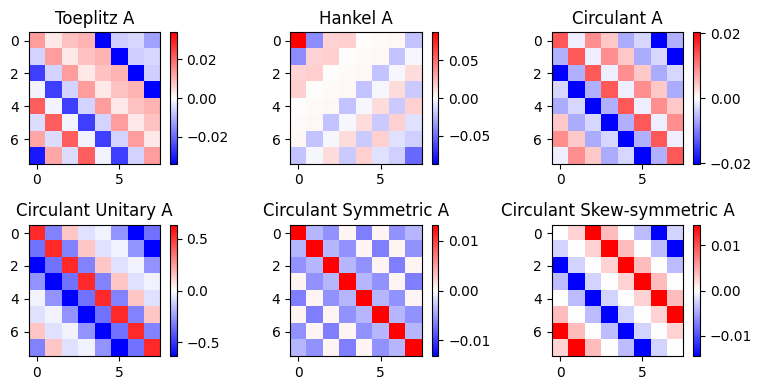

In [8]:
# Define and fit shift-equivariant PiDMD models.
pidmd_s1 = PiDMD(manifold="toeplitz", compute_A=True).fit(X)
pidmd_s2 = PiDMD(manifold="hankel", compute_A=True).fit(X)
pidmd_s3 = PiDMD(manifold="circulant", compute_A=True).fit(X)
pidmd_s4 = PiDMD(manifold="circulant_unitary", compute_A=True).fit(X)
pidmd_s5 = PiDMD(manifold="circulant_symmetric", compute_A=True).fit(X)
pidmd_s6 = PiDMD(manifold="circulant_skewsymmetric", compute_A=True).fit(X)

# Plot the computed A matrices (real components).
plot_matrices(
    figsize=(8, 4), grid=(2, 3),
    matrices=[pidmd_s1.A, pidmd_s2.A, pidmd_s3.A, pidmd_s4.A, pidmd_s5.A, pidmd_s6.A], 
    titles=["Toeplitz A", "Hankel A", "Circulant A",
            "Circulant Unitary A", "Circulant Symmetric A", "Circulant Skew-symmetric A"],
)

## Multi-dimensional extensions
Finally, when dealing with data collected from a multi-dimensional grid where shift-equivariance applies along specific axes of data collection, one may wish to turn to a manifold of *block circulant* (BC) matrices, several of which have been implemented in PyDMD. These are again manifolds which may be specified via the `manifold` argument of the `PiDMD` model, as demonstrated below. Notice that like the `"diagonal"` manifold, this choice of manifold must be paired with the `PiDMD` model argument `manifold_opt=(a, b)`, which specifies the desired dimensions of each block of the computed block circulant operator $\mathbf{A}$.

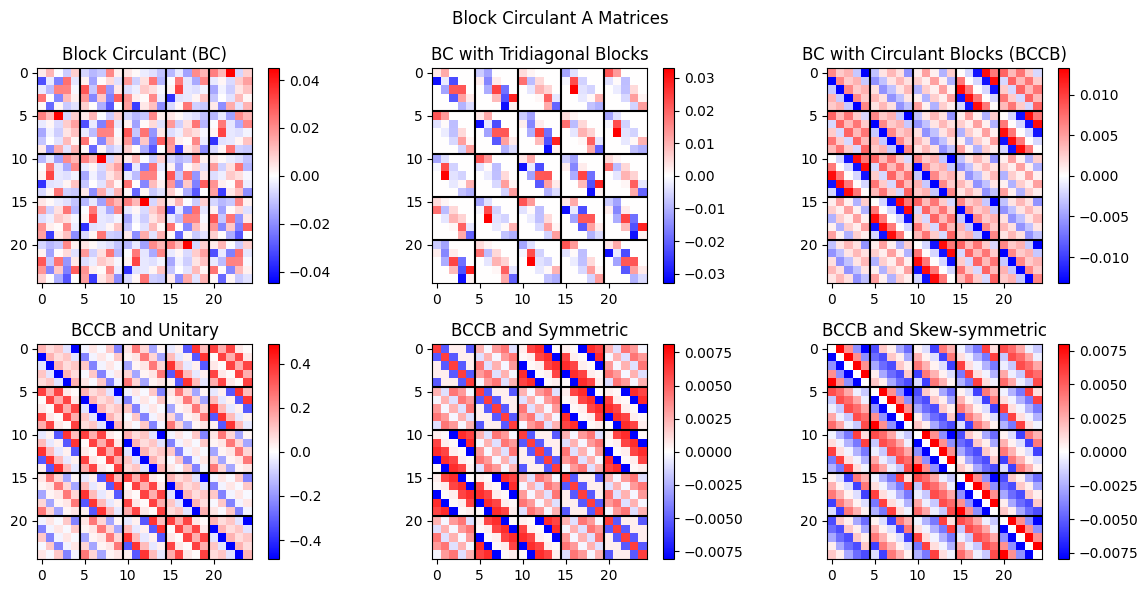

In [9]:
# Re-define test data and test data sizes
n = 5 # blocks will be n x n
X = rng.standard_normal((n ** 2, nt))

# Define and fit block circulant PiDMD models.
pidmd_b1 = PiDMD(manifold="BC", manifold_opt=(n, n), compute_A=True).fit(X)
pidmd_b2 = PiDMD(manifold="BCTB", manifold_opt=(n, n), compute_A=True).fit(X)
pidmd_b3 = PiDMD(manifold="BCCB", manifold_opt=(n, n), compute_A=True).fit(X)
pidmd_b4 = PiDMD(manifold="BCCBunitary", manifold_opt=(n, n), compute_A=True).fit(X)
pidmd_b5 = PiDMD(manifold="BCCBsymmetric", manifold_opt=(n, n), compute_A=True).fit(X)
pidmd_b6 = PiDMD(manifold="BCCBskewsymmetric", manifold_opt=(n, n), compute_A=True).fit(X)

# Store and specify the A matrices and their names.
matrices = [pidmd_b1.A, pidmd_b2.A, pidmd_b3.A, pidmd_b4.A, pidmd_b5.A, pidmd_b6.A]
titles = [
    "Block Circulant (BC)",
    "BC with Tridiagonal Blocks",
    "BC with Circulant Blocks (BCCB)", 
    "BCCB and Unitary",
    "BCCB and Symmetric",
    "BCCB and Skew-symmetric",
]

# Plot all A matrices (real components).
plt.figure(figsize=(12, 6))
plt.suptitle("Block Circulant A Matrices")
for i, (A, title) in enumerate(zip(matrices, titles)):
    vmax = np.abs(A).max()
    plt.subplot(2, 3, i + 1)
    plt.title(title)
    plt.imshow(A.real, cmap="bwr", vmax=vmax, vmin=-vmax)
    for j in range(n - 1):
        plt.axhline(y=(j+1)*n-0.5, c="k")
        plt.axvline(x=(j+1)*n-0.5, c="k")
    plt.colorbar()
plt.tight_layout()
plt.show()

## Part 2: Application to a Toy System
Consider the discrete-time flow $\mathbf{x}_{k+1} = \mathbf{A}\mathbf{x}_{k}$, which we define as follows. Here, we consider this system over fifty time points, with $x_0 = -1$ and $y_0=1$.

$$
\begin{pmatrix}
x_{k+1} \\ y_{k+1}
\end{pmatrix}
= 
\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\ 1 & -1
\end{pmatrix}
\begin{pmatrix}
x_{k} \\ y_{k}
\end{pmatrix}
$$

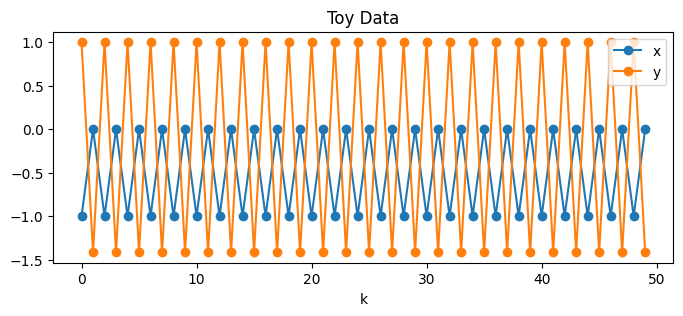

In [10]:
# Define the true A operator, the initial condition, and the number of time points.
A_true = (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]])
initial = np.array([-1, 1])
T = 50

# Simulate the discrete-time flow.
X_clean = np.empty((2, T))
X_clean[:, 0] = initial
for i in range(T - 1):
    X_clean[:, i+1] = A_true.dot(X_clean[:, i])

# Plot the toy data.
plt.figure(figsize=(8, 3))
plt.plot(X_clean[0], "-o", label="x")
plt.plot(X_clean[1], "-o", label="y")
plt.title("Toy Data")
plt.xlabel("k")
plt.legend()
plt.show()

Notice that the true operator $\mathbf{A}$ is *unitary* by definition, hence we can use `PiDMD` with the `manifold="unitary"` tag in order to model our data.

In [11]:
print(A_true.conj().T.dot(A_true))

[[ 1.00000000e+00 -2.23711432e-17]
 [-2.23711432e-17  1.00000000e+00]]


Since we could alternatively fit a regular `DMD` model to our data, we compare the performance of `DMD` and `PiDMD` as we pollute our dataset with Gaussian noise. In particular, we examine a variety of noise magnitudes, all while examining multiple instantiations of measurement noise per noise magnitude value. We then fit our DMD models to the noisy data and use our models' ability to recover the true eigenvalues of the system as a proxy for accurate model-building.

In [12]:
# Get the true eigenvalues of the system.
true_eigs = np.sort(np.linalg.eig(A_true)[0])

# Specify the noise magnitude values to examine and the number of trials per magnitude value.
num_trials = 100
noise_mags = np.logspace(-16, -1, 16)
eig_error_dmd = np.empty((len(noise_mags), num_trials))
eig_error_pidmd = np.empty((len(noise_mags), num_trials))

for i, sigma in enumerate(noise_mags):
    for j in range(num_trials):
        # Add an instantiation of noise to the clean data.
        X = X_clean + (sigma * np.random.randn(*X_clean.shape))
        # Fit noisy data to a DMD and a PiDMD model.
        dmd = DMD(svd_rank=2).fit(X)
        pidmd = PiDMD(manifold="unitary", svd_rank=2).fit(X)
        # Compare computed eigenvalues to the ground truth.
        eig_error_dmd[i, j] = compute_error(true_eigs, np.sort(dmd.eigs))
        eig_error_pidmd[i, j] = compute_error(true_eigs, np.sort(pidmd.eigs))

Notice that regular DMD degrades as the magnitude of noise pollution increases, while PiDMD demonstrates greater robustness to noise. 

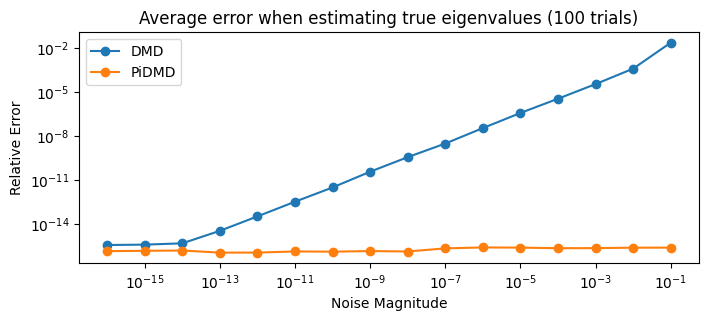

In [13]:
# Plot noise experiment results.
plt.figure(figsize=(8, 3))
plt.plot(noise_mags, np.average(eig_error_dmd, axis=1), "-o", label="DMD")
plt.plot(noise_mags, np.average(eig_error_pidmd, axis=1), "-o", label="PiDMD")
plt.title(f"Average error when estimating true eigenvalues ({num_trials} trials)")
plt.xlabel("Noise Magnitude")
plt.ylabel("Relative Error")
plt.semilogx()
plt.semilogy()
plt.legend()
plt.show()

For more applications of PiDMD and for more discussions on how one might apply PiDMD to real-world data, we refer readers to the original PiDMD paper [1].